<a href="https://colab.research.google.com/github/amirAHS2000/nn_and_dl/blob/master/makemore_part3_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# read in all the words
words = open('/content/drive/MyDrive/nn_zero_to_hero_course/data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [40]:
len(words)

32033

In [41]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))

# characters to index dictionary (start with index one)
stoi = {s:i+1 for i,s in enumerate(chars)}
# add special character at index zero
stoi['.'] = 0
# index to character dictionary
itos = {i:s for s,i in stoi.items()}
# vocabulary size
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [42]:
# build the dataset

# context length: how many characters do we take to predict the next one?
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    # for each word first add fully dot ([., ., ., ., .] or [0, 0, 0, 0, 0])
    context = [0] * block_size
    # iterating over each character of the current word (add special character at the end of word)
    for ch in w + '.':
      # index of the next character in the current word
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  # convert lists to tensors
  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)

  return X, Y

In [43]:
import random


random.seed(42)

# shuffle operation here is important (specific ordering of the data may be cause problem)
random.shuffle(words)
# define the numbers which use for splitting the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train, dev, test set
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix (dim: number of characters * dim of each character)
C = torch.randn((vocab_size, n_embd), generator=g)
# initializing weights and biases (kaiming initialization)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) /((n_embd * block_size)**0.5)
# because we using BatchNorm after the multiplication, this bias has no effect
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# keep tracking of mean and std of the data during training process (not trainable)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct

  # generating a list of random number (size: mini-batch) (range: 0 to number of training data)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatanate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # no need to gradient calculation
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.2879
  10000/ 200000: 2.3239
  20000/ 200000: 2.0221
  30000/ 200000: 2.0298
  40000/ 200000: 2.0629
  50000/ 200000: 2.8945
  60000/ 200000: 2.1050
  70000/ 200000: 2.8188
  80000/ 200000: 2.5734
  90000/ 200000: 2.2486
 100000/ 200000: 2.0447
 110000/ 200000: 1.8231
 120000/ 200000: 1.8341
 130000/ 200000: 2.4104
 140000/ 200000: 2.4917
 150000/ 200000: 2.4235
 160000/ 200000: 2.1188
 170000/ 200000: 2.1723
 180000/ 200000: 2.1491
 190000/ 200000: 2.1050


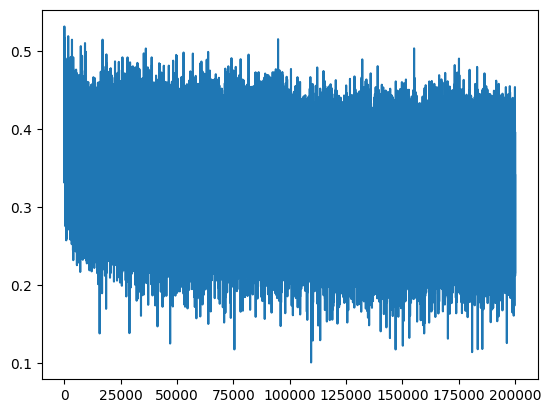

In [47]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [48]:
@torch.no_grad() # this decorator disable gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)

  print(split, loss.item())

In [49]:
split_loss('train')
split_loss('val')

train 2.067195415496826
val 2.105731964111328


**Loss Log**

*original:*\
train 2.1245384216308594 val 2.168196439743042

*fix softmax confidently wrong:*\
train 2.07 val 2.13

*fix tanh layer too saturated at init:*\
train 2.0355966091156006 val 2.1026785373687744

*use semi-principled "kaiming init" instead of hacky init:*\
train 2.0376641750335693 val 2.106989622116089

*add batch norm layer*\
train 2.0668270587921143 val 2.104844808578491

# Pytorchifying

In [50]:
# train a deeper networ
# the classes we create here are the same API as nn.Module in Pytorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [51]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [52]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [54]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [55]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update / data ratio

for i in range(max_steps):

  # minibatch construct

  # indexes of data in minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()


  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


# Visualization histograms